                            Challenge 2: Anticipating Household Displacement in Communities

Mapping census tracts in LA County experiencing high rent burden

Data Sources: (all referenced from the US census.gov website)

- American Community Survey 2022 (5 year estimates) for Housing Costs (AKA B25070)
- American Community Survey 2022 (5 year estimates) for Demographic Data (AKA DP05)
- TIGER/Line Shapefile of CA from 2022

[Further discussion on GH](https://github.com/datakind/datakit-housing-fall-2024/discussions/23)

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# import data from local files
data = pd.read_csv(r'..\..\..\Census Data\American Community Survey\Housing Costs B25070\5 Year Estimates\ACSDT5Y2022.B25070-Data.csv')
geodata_CA = gpd.read_file(r'..\..\..\Census Data\GeoData Tiger Line\tl_2023_06_tract.shp')
demographic_data_raw = pd.read_csv(r'..\..\..\Census Data\American Community Survey\Demographics DP05\ACSDP5Y2022.DP05-Data.csv', low_memory=False)

### Data Wrangling

In [3]:
# Simplifying the geometry a bit to reduce file size for sharing
#geodata_CA['geometry'] = geodata_CA.geometry.simplify(tolerance=0.001)

In [4]:
# limiting data to include only LA County and Orange County (based on Country FIPS codes 037 and 059, respectively)
geodata_CA = geodata_CA.loc[(geodata_CA['COUNTYFP'].str.contains('037'))|
                            (geodata_CA['COUNTYFP'].str.contains('059'))]

In [ ]:
# dropping margin of error columns
data = data.drop(columns= ['B25070_001M', 'B25070_002M', 'B25070_003M', 'B25070_004M', 'B25070_005M', 'B25070_006M', 'B25070_007M', 'B25070_008M', 'B25070_009M', 'B25070_010M', 'B25070_011M', 'Unnamed: 24'], axis = 1)

In [5]:
# keeping the percentage-based demographic columns (getting rid of margin of error data, total counts, unnamed: 366)
drop_these = []
for column in demographic_data_raw.columns:
    if (not column.endswith('PE')) and (column not in ['GEO_ID', 'NAME']) or (column.endswith('M')):
        drop_these.append(column)
print(drop_these)

['DP05_0001E', 'DP05_0001M', 'DP05_0002E', 'DP05_0002M', 'DP05_0003E', 'DP05_0003M', 'DP05_0004E', 'DP05_0004M', 'DP05_0005E', 'DP05_0005M', 'DP05_0006E', 'DP05_0006M', 'DP05_0007E', 'DP05_0007M', 'DP05_0008E', 'DP05_0008M', 'DP05_0009E', 'DP05_0009M', 'DP05_0010E', 'DP05_0010M', 'DP05_0011E', 'DP05_0011M', 'DP05_0012E', 'DP05_0012M', 'DP05_0013E', 'DP05_0013M', 'DP05_0014E', 'DP05_0014M', 'DP05_0015E', 'DP05_0015M', 'DP05_0016E', 'DP05_0016M', 'DP05_0017E', 'DP05_0017M', 'DP05_0018E', 'DP05_0018M', 'DP05_0019E', 'DP05_0019M', 'DP05_0020E', 'DP05_0020M', 'DP05_0021E', 'DP05_0021M', 'DP05_0022E', 'DP05_0022M', 'DP05_0023E', 'DP05_0023M', 'DP05_0024E', 'DP05_0024M', 'DP05_0025E', 'DP05_0025M', 'DP05_0026E', 'DP05_0026M', 'DP05_0027E', 'DP05_0027M', 'DP05_0028E', 'DP05_0028M', 'DP05_0029E', 'DP05_0029M', 'DP05_0030E', 'DP05_0030M', 'DP05_0031E', 'DP05_0031M', 'DP05_0032E', 'DP05_0032M', 'DP05_0033E', 'DP05_0033M', 'DP05_0034E', 'DP05_0034M', 'DP05_0035E', 'DP05_0035M', 'DP05_0036E', 'DP05

In [6]:
demographic_data = demographic_data_raw.drop(columns=drop_these, axis=1)

In [7]:
# Changing headers
data.columns = data.iloc[0,:]
data = data.iloc[1:,:]
data = data.reset_index()

demographic_data.columns = demographic_data.iloc[0,:]
demographic_data = demographic_data.iloc[1:,:]
demographic_data = demographic_data.reset_index()

In [8]:
# There are 4 columns with duplicated column names in this dataset. This removes them
demographic_data = demographic_data.loc[:, ~demographic_data.columns.duplicated()]

In [9]:
def parse_GEOID(long_GEOID):
    _, short_form = long_GEOID.split('US')
    return short_form

In [10]:
# Match GEOIDs from both dataframes by parsing the longer version from the ACS data
data['GEOID'] = data['Geography'].apply(parse_GEOID)
demographic_data['GEOID'] = demographic_data['Geography'].apply(parse_GEOID)

In [11]:
# drop now-defunct Geography & old index columns
data= data.drop(columns = ['Geography', 'index'], axis =1)
demographic_data= demographic_data.drop(columns = ['Geography', 'index'], axis =1)

In [12]:
# "Burdened" here means spending more than 30% of the household income on rent
# Census tracts with 0 survey replies will be "calculated" as having "Insufficient survey results"
def calculate_burdened_individuals (row):
    over_30 = (row[7:11].astype('float')).sum()
    percentage_over_30 = over_30 / float(row.iloc[1]) if float(row.iloc[1]) != 0 else "Insufficient survey results"
    return over_30, percentage_over_30

In [13]:
result = pd.DataFrame()
result['number_burdened'], result['proportion_burdened'] = zip(*data.apply(calculate_burdened_individuals, axis = 1))

In [32]:
data

,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!Less than 10.0 percent,Margin of Error!!Total:!!Less than 10.0 percent,Estimate!!Total:!!10.0 to 14.9 percent,Margin of Error!!Total:!!10.0 to 14.9 percent,Estimate!!Total:!!15.0 to 19.9 percent,Margin of Error!!Total:!!15.0 to 19.9 percent,Estimate!!Total:!!20.0 to 24.9 percent,...,Estimate!!Total:!!40.0 to 49.9 percent,Margin of Error!!Total:!!40.0 to 49.9 percent,Estimate!!Total:!!50.0 percent or more,Margin of Error!!Total:!!50.0 percent or more,Estimate!!Total:!!Not computed,Margin of Error!!Total:!!Not computed,NaN,GEOID,number_burdened,proportion_burdened
0,Census Tract 4001; Alameda County; California,127,60,20,22,8,12,81,60,0,...,8,13,0,13,0,13,NaN,06001400100,154.0,1.212598
1,Census Tract 4002; Alameda County; California,386,79,69,34,43,22,80,35,41,...,5,7,28,20,0,13,NaN,06001400200,186.0,0.481865
2,Census Tract 4003; Alameda County; California,1691,246,182,86,173,78,296,144,151,...,93,119,189,98,73,82,NaN,06001400300,663.0,0.392076
3,Census Tract 4004; Alameda County; California,887,163,141,105,106,51,244,105,153,...,17,17,171,103,0,13,NaN,06001400400,569.0,0.641488
4,Census Tract 4005; Alameda County; California,878,118,19,21,107,56,119,45,50,...,55,45,225,85,13,16,NaN,06001400500,252.0,0.287016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,Census Tract 409.02; Yuba County; California,479,82,0,13,8,12,27,24,47,...,9,13,169,70,146,73,NaN,06115040902,123.0,0.256785
9125,Census Tract 410.01; Yuba County; California,320,181,9,18,6,11,0,13,9,...,0,13,106,113,167,158,NaN,06115041001,40.0,0.125
9126,Census Tract 410.02; Yuba County; California,312,175,0,13,0,13,68,83,22,...,0,13,52,81,158,137,NaN,06115041002,203.0,0.650641
9127,Census Tract 411.01; Yuba County; California,276,127,0,13,0,13,21,19,9,...,64,83,60,47,82,64,NaN,06115041101,66.0,0.23913


In [14]:
result

,number_burdened,proportion_burdened
0,154.0,1.212598
1,186.0,0.481865
2,663.0,0.392076
3,569.0,0.641488
4,252.0,0.287016
...,...,...
9124,123.0,0.256785
9125,40.0,0.125
9126,203.0,0.650641
9127,66.0,0.23913


In [15]:
# Add the calculated burdened data to the original dataframe
data = data.join(result)

In [16]:
data = data.loc[data['proportion_burdened'] != 'Insufficient survey results']

In [17]:
# looking at census tracts with highest proportions of cost-burdened renters
data['Geographic Area Name'].loc[data['proportion_burdened'] >= (data['proportion_burdened'].quantile(0.95))]

0       Census Tract 4001; Alameda County; California
106     Census Tract 4099; Alameda County; California
107     Census Tract 4100; Alameda County; California
121     Census Tract 4211; Alameda County; California
159     Census Tract 4262; Alameda County; California
                            ...                      
9068     Census Tract 103.15; Yolo County; California
9097     Census Tract 112.03; Yolo County; California
9103     Census Tract 112.11; Yolo County; California
9111     Census Tract 402.01; Yuba County; California
9123     Census Tract 409.01; Yuba County; California
Name: Geographic Area Name, Length: 452, dtype: object

In [18]:
# confirming GEOIDs match
geodata_CA['GEOID']

2       06037204920
3       06037205110
4       06037320101
5       06037205120
6       06037206010
           ...     
9113    06037181400
9124    06059001303
9125    06059001304
9126    06059001401
9128    06037578100
Name: GEOID, Length: 3112, dtype: object

In [19]:
data['GEOID']

0       06001400100
1       06001400200
2       06001400300
3       06001400400
4       06001400500
           ...     
9124    06115040902
9125    06115041001
9126    06115041002
9127    06115041101
9128    06115041102
Name: GEOID, Length: 9031, dtype: object

In [20]:
demographic_data['GEOID']

0       06001400100
1       06001400200
2       06001400300
3       06001400400
4       06001400500
           ...     
9124    06115040902
9125    06115041001
9126    06115041002
9127    06115041101
9128    06115041102
Name: GEOID, Length: 9129, dtype: object

In [21]:
# Convert GeoIDs to strings
geodata_CA['GEOID'] = geodata_CA['GEOID'].astype(str)
data['GEOID'] = data['GEOID'].astype(str)
demographic_data['GEOID'] = demographic_data['GEOID'].astype(str)

In [22]:
# Check the unique GEOID values in each dataset
gdf_geoids = set(geodata_CA['GEOID'].unique())
renter_geoids = set(data['GEOID'].unique())
demo_geoids = set(demographic_data['GEOID'].unique())

# Find the GEOIDs present in gdf but not in renter data & visa versa
missing_in_renter = gdf_geoids - renter_geoids
missing_in_gdf = renter_geoids - gdf_geoids
missing_in_demo = gdf_geoids - demo_geoids

print(f"GEOIDs in shapefile but not in renter data: {len(missing_in_renter)}")
print(f"GEOIDs in renter data but not in shapefile: {len(missing_in_gdf)}")
print(f"GEOIDs in demographic data but not in shapefile: {len(missing_in_demo)}")


GEOIDs in shapefile but not in renter data: 35
GEOIDs in renter data but not in shapefile: 5954
GEOIDs in demographic data but not in shapefile: 0


In [23]:
# Merge geodata + renter dataframes on geoids
geodata_merged = geodata_CA.merge(data, how= 'inner', on='GEOID')
geodata_merged = geodata_merged.merge(demographic_data, how= 'inner', on= ['GEOID', 'Geographic Area Name'])

In [24]:
# Dropping columns that aren't necessary
geodata_merged = geodata_merged.drop(columns=['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOIDFQ', 'NAME', 'MTFCC', 'FUNCSTAT', 'ALAND','AWATER', 'INTPTLAT', 'INTPTLON','NAMELSAD'], axis = 1)

### Visualizations

<Axes: >

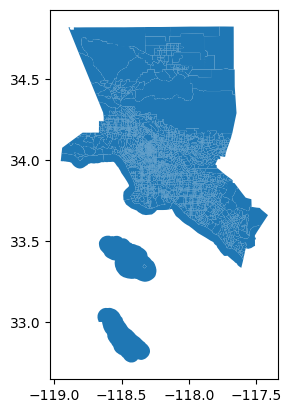

In [25]:
geodata_CA.plot()

In [26]:
# Giving columns reader-friendly names for map legends
geodata_merged = geodata_merged.rename(columns={
    "Estimate!!Total:": "Total Households", "Estimate!!Total:!!Less than 10.0 percent": "<10% Income Spent on Rent", 'Estimate!!Total:!!10.0 to 14.9 percent': '10-14.9% Income Spent on Rent', 'Estimate!!Total:!!15.0 to 19.9 percent': '15-19.9% Income Spent on Rent', 'Estimate!!Total:!!20.0 to 24.9 percent': '20-24.9% Income Spent on Rent',  'Estimate!!Total:!!25.0 to 29.9 percent': '25-29.9% Income Spent on Rent', 'Estimate!!Total:!!30.0 to 34.9 percent': '30-34.9% Income Spent on Rent', 'Estimate!!Total:!!35.0 to 39.9 percent': '35-39.9% Income Spent on Rent', 'Estimate!!Total:!!40.0 to 49.9 percent': '40-49.9% Income Spent on Rent', 'Estimate!!Total:!!50.0 percent or more': '50+% Income Spent on Rent', 'Estimate!!Total:!!Not computed': 'Rent Expenditure Unknown', 'number_burdened': 'Number of Rent-Burdened Households (>30% Expenditure)', 'proportion_burdened': 'Proportion of Rent Burdened Households', 'Percent!!Race alone or in combination with one or more other races!!Total population!!Black or African American': 'Percent Black (alone or in combination with other races)', 'Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)': 'Percent Hispanic or Latino (alone or in combination with other races)', 'Percent!!Race alone or in combination with one or more other races!!Total population!!Asian': 'Percent Asian (alone or in combination with other races)', 'Percent!!RACE!!Total population!!One race!!White': 'Percent White'})

In [27]:
# converting strings to numeric for better plotting 
geodata_merged['Proportion of Rent Burdened Households'] = pd.to_numeric(
    geodata_merged['Proportion of Rent Burdened Households'],
    errors='coerce')
geodata_merged['Percent Black (alone or in combination with other races)'] = pd.to_numeric(
    geodata_merged['Percent Black (alone or in combination with other races)'],
    errors='coerce'
)

Text(0.5, 1.0, 'Proportion of Cost-Burdened Renter Households per Census Tract')

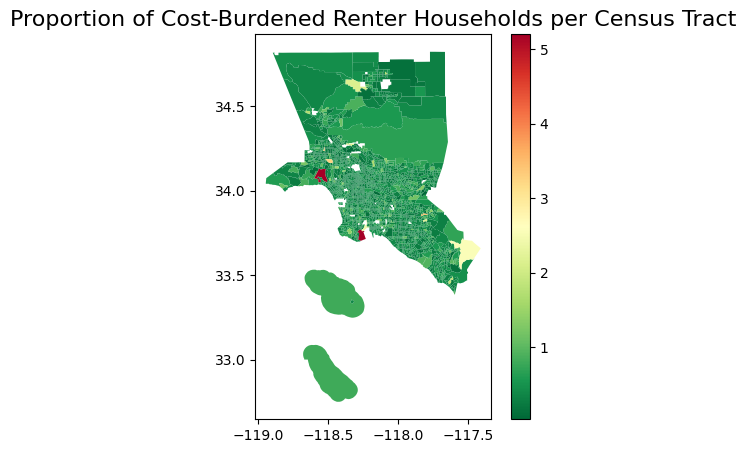

In [28]:
# Plotting static image
fig, ax = plt.subplots(figsize=(5,5))
geodata_merged.plot(column = 'Proportion of Rent Burdened Households', cmap ='RdYlGn_r', legend = True, ax=ax)
ax.set_title('Proportion of Cost-Burdened Renter Households per Census Tract', fontsize=16)
#plt.savefig('CA Cost Burdened Households.png')

C:\Users\wisery\AppData\Local\Temp\ipykernel_123136\2078099094.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')


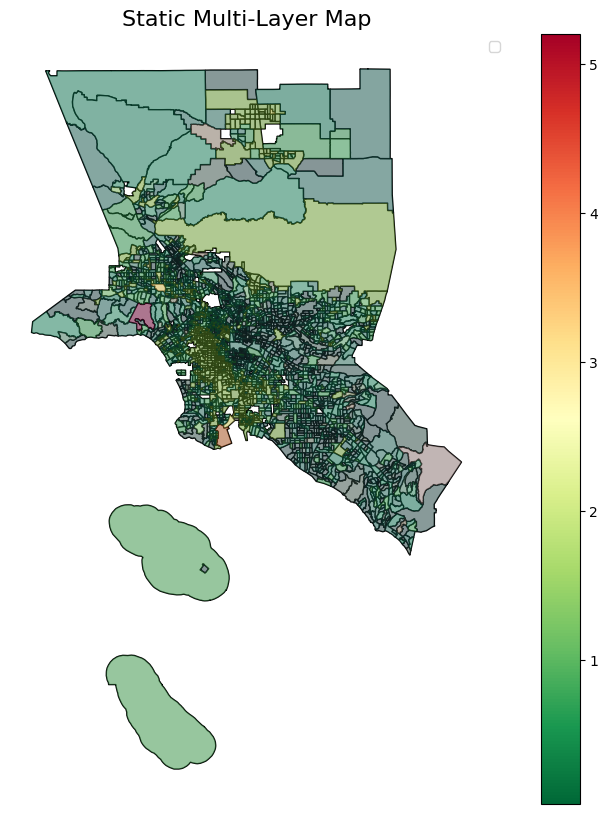

In [29]:
# Making a non-interactable/static map with layers 
# I don't like how this looks, but maybe this code can be useful for someone else?
fig, ax = plt.subplots(figsize=(15, 10))
geodata_merged.plot(ax=ax, color='lightgray', edgecolor='black')
race_layer = geodata_merged.plot(ax=ax, column='Percent Black (alone or in combination with other races)', scheme='quantiles', legend=True, alpha=0.25)
rent_layer = geodata_merged.plot(ax=ax, column='Proportion of Rent Burdened Households', cmap = 'RdYlGn_r', legend=True, alpha=0.25)
ax.axis('off')
ax.set_title('Static Multi-Layer Map', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')

In [30]:
# Plotting interactable map w/ layers to allow additional demographics data later
import folium

# Base map has rent burdened choropleth overlay
map = geodata_merged.explore(
    column= 'Proportion of Rent Burdened Households', 
    name= 'Proportion of Rent Burdened Households', 
    cmap='RdYlGn_r', 
    legend= True, 
    figsize= (15,15),
    tooltip= [
        'Geographic Area Name', 'Total Households', r'Number of Rent-Burdened Households (>30% Expenditure)', 'Proportion of Rent Burdened Households', 'Percent White', 'Percent Black (alone or in combination with other races)', 'Percent Hispanic or Latino (alone or in combination with other races)', 'Percent Asian (alone or in combination with other races)'])

# adding ethnicity overlay as a layer
#geodata_merged.explore(
#    column='Percent White', 
#    name='Ethnicity Overlay', 
#    cmap='Blues_r', 
#    legend=False,
#    tooltip=[
#        'Geographic Area Name', 'Percent White', 'Percent Black (alone or in #combination with other races)', 'Percent Hispanic or Latino (alone or #in combination with other races)', 'Percent Asian (alone or in #combination with other races)'
#    ],
#    figsize=(15, 15),
#    m=map  
#)
folium.LayerControl().add_to(map)
map

UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [31]:
# save as HTML file for sharing
# map.save("LA + Orange Counties.html")